In [11]:
import cv2

import sys
import os

sys.path.append('lib.py')
from lib import *

In [12]:
# 输入图像
# source_path = 'mri_source.png'
source_path = 'mri_source.png'
target_path = 'mri_target.png'
# mask图像保存位置
test_out_folder = './out/'
source_mask_out_path = './out/mri_source_mask.png'
target_mask_out_path = './out/mri_target_mask.png'
# 处理后的source图像
output_balanced_path = './out/mri_source_balanced.png'
output_matched_path = './out/mri_source_matched.png'
output_balanced_matched_path_1 = './out/mri_source_balanced+matched1.png'
output_balanced_matched_path_2 = './out/mri_source_balanced+matched2.png'

# 处理flag
USE_MASK_FLAG = True
REPLACE_BG_FLAG = True

if not os.path.exists(test_out_folder):
    os.mkdir(test_out_folder)

### 获取图片mask的方法

参考：https://github.com/danielgatis/rembg

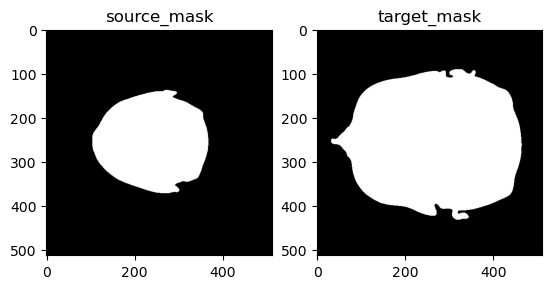

In [13]:
# 获取source mask
source_mask = getMask(path=source_path, save=source_mask_out_path)
# 获取target mask
target_mask = getMask(path=target_path, save=target_mask_out_path)

plt.subplot(1, 2, 1)
plt.imshow(source_mask, cmap='gray', vmin=0, vmax=255)
plt.title("source_mask")
plt.subplot(1, 2, 2)
plt.imshow(target_mask, cmap='gray', vmin=0, vmax=255)
plt.title("target_mask")
plt.show()

### 直方图均衡化example

(512, 512)


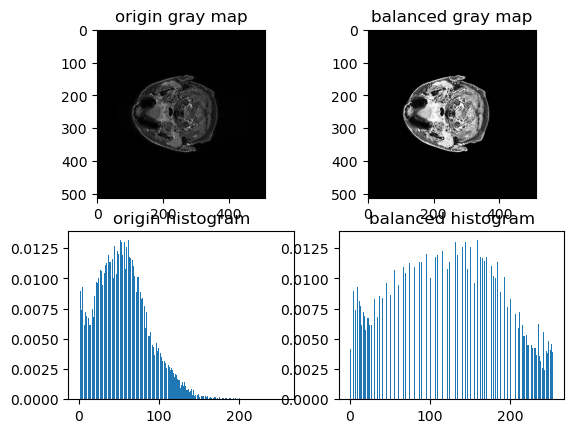

In [14]:
#打开文件并灰度化
# im_s = Image.open(source_path).convert("L")
im_s = cv2.imread(source_path, cv2.IMREAD_GRAYSCALE)
im_s_arr = np.array(im_s)
print(np.shape(im_s_arr))

#开始绘图，分成四个部分
plt.figure()
plt.subplot(2, 2, 1)
plt.imshow(im_s_arr, cmap='gray', vmin=0, vmax=255)
plt.title("origin gray map")

#创建原始直方图
plt.subplot(2, 2, 3)
hist_s_in_mask = arrayToHist(im_s_arr, 256, use_mask=USE_MASK_FLAG, mask=source_mask)
drawHist(hist_s_in_mask, "origin histogram")

#计算均衡化的新的图片，根据累计直方图
im_s_arr_balanced = equalization(im_s_arr, hist_s_in_mask, 256, use_mask=USE_MASK_FLAG, mask=source_mask,
                                 replace_bg=REPLACE_BG_FLAG)
plt.subplot(2, 2, 2)
plt.imshow(im_s_arr_balanced, cmap="gray", vmin=0, vmax=255)
plt.title("balanced gray map")
#保存均衡化后的图片
im_d_out = Image.fromarray(im_s_arr_balanced, mode='L')
im_d_out.save(output_balanced_path)

#根据新的图片的数组，计算新的直方图
plt.subplot(2, 2, 4)
hist_s_balanced_in_mask = arrayToHist(im_s_arr_balanced, 256, use_mask=USE_MASK_FLAG, mask=source_mask)
drawHist(hist_s_balanced_in_mask, "balanced histogram")

plt.show()

In [15]:
# 观察balance后的亮度统计
countArray(im_s_arr_balanced.flatten())

0      215928
138       612
160       610
128       609
145       600
        ...  
238       146
239       138
241       119
243       113
255        95
Length: 125, dtype: int64

### 直方图匹配example：使用单张图片作为目标直方图

(512, 512)
(512, 512)


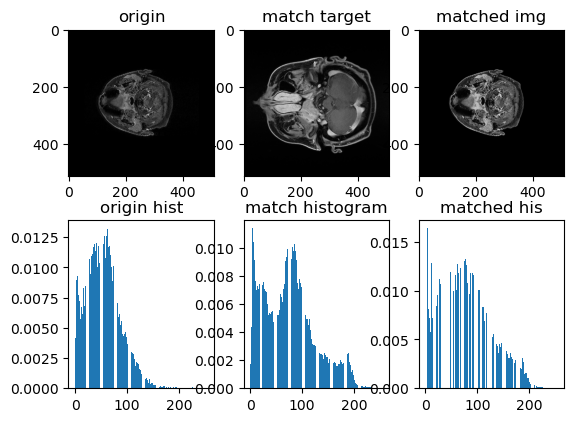

In [16]:
#打开文件并灰度化
im_s = cv2.imread(source_path, cv2.IMREAD_GRAYSCALE)
im_s_arr = np.array(im_s)
print(np.shape(im_s_arr))
#打开目标文件并灰度化（这里用单张图作为目标直方图的参考）
im_match = cv2.imread(target_path, cv2.IMREAD_GRAYSCALE)
im_match_arr = np.array(im_match)
print(np.shape(im_match_arr))

#原始图和直方图
plt.subplot(2, 3, 1)
plt.title("origin")
plt.imshow(im_s, cmap='gray', vmin=0, vmax=255)

plt.subplot(2, 3, 4)
hist_s = arrayToHist(im_s_arr, 256, use_mask=USE_MASK_FLAG, mask=source_mask)
drawHist(hist_s, "origin hist")

#match图和其直方图
plt.subplot(2, 3, 2)
plt.title("match target")
plt.imshow(im_match, cmap='gray', vmin=0, vmax=255)

plt.subplot(2, 3, 5)
hist_m = arrayToHist(im_match_arr, 256, use_mask=USE_MASK_FLAG, mask=target_mask)
drawHist(hist_m, "match histogram")

#match后的图片及其直方图 将目标图的直方图用于给原图做均衡，也就实现了match
im_s_matched_arr = histMatch(im_s_arr, hist_m, use_mask=USE_MASK_FLAG, mask=source_mask, replace_bg=REPLACE_BG_FLAG)
plt.subplot(2, 3, 3)
plt.title("matched img")
plt.imshow(im_s_matched_arr, cmap='gray', vmin=0, vmax=255)
#保存match后的图片
im_out_matched = Image.fromarray(im_s_matched_arr, mode='L')
im_out_matched.save(output_matched_path)

plt.subplot(2, 3, 6)
hist_d = arrayToHist(im_s_matched_arr, 256, use_mask=True, mask=source_mask)
drawHist(hist_d, "matched his")

plt.show()

In [17]:
# 观察match后的亮度统计
countArray(im_s_matched_arr.flatten())

0      215928
4         757
17        658
7         640
77        612
        ...  
219         1
236         1
245         1
241         1
234         1
Length: 178, dtype: int64

### source和target均衡化后再match:example

In [18]:
#打开文件并灰度化
im_s = cv2.imread(source_path, cv2.IMREAD_GRAYSCALE)
im_s_arr = np.array(im_s)
print(np.shape(im_s_arr))
im_t = cv2.imread(target_path, cv2.IMREAD_GRAYSCALE)
im_t_arr = np.array(im_t)
print(np.shape(im_t_arr))

(512, 512)
(512, 512)


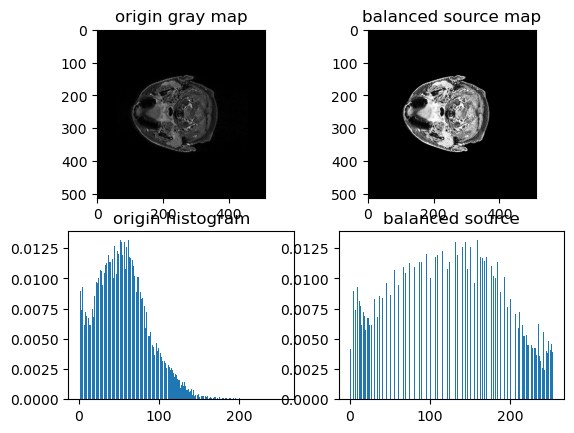

In [19]:
# 1 origin
plt.figure()
plt.subplot(2, 2, 1)
plt.imshow(im_s_arr, cmap='gray', vmin=0, vmax=255)
plt.title("origin gray map")

# 2 origin 直方图
plt.subplot(2, 2, 3)
hist_s_in_mask = arrayToHist(im_s_arr, 256, use_mask=USE_MASK_FLAG, mask=source_mask)
drawHist(hist_s_in_mask, "origin histogram")

# 3 source balanced
im_s_arr_balanced = equalization(im_s_arr, hist_s_in_mask, 256, use_mask=USE_MASK_FLAG, mask=source_mask,
                                 replace_bg=REPLACE_BG_FLAG)
plt.subplot(2, 2, 2)
plt.imshow(im_s_arr_balanced, cmap="gray", vmin=0, vmax=255)
plt.title("balanced source map")

# 4 source balanced 直方图
plt.subplot(2, 2, 4)
hist_s_balanced_in_mask = arrayToHist(im_s_arr_balanced, 256, use_mask=USE_MASK_FLAG, mask=source_mask)
drawHist(hist_s_balanced_in_mask, "balanced source")

plt.show()

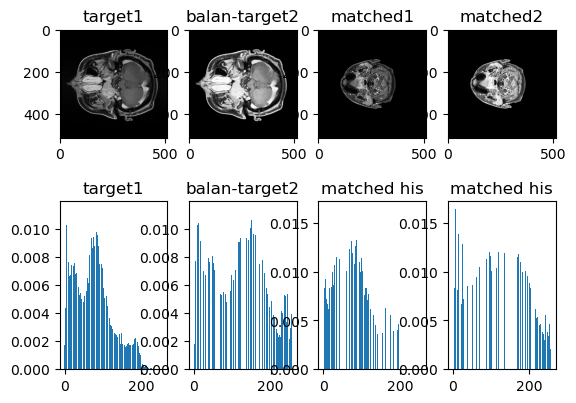

In [20]:
# 1 target
plt.figure()
plt.subplot(2, 4, 1)
plt.imshow(im_t_arr, cmap='gray', vmin=0, vmax=255)
plt.title("target1")

# 2 target 直方图
plt.subplot(2, 4, 5)
hist_t_in_mask = arrayToHist(im_t_arr, 256, use_mask=USE_MASK_FLAG, mask=target_mask)
drawHist(hist_t_in_mask, "target1")

# 3 target balanced
im_t_arr_balanced = equalization(im_t_arr, hist_t_in_mask, 256, use_mask=USE_MASK_FLAG, mask=target_mask,
                                 replace_bg=REPLACE_BG_FLAG)
plt.subplot(2, 4, 2)
plt.imshow(im_t_arr_balanced, cmap="gray", vmin=0, vmax=255)
plt.title("balan-target2")

# 4 target balanced 直方图
plt.subplot(2, 4, 6)
hist_t_balanced_in_mask = arrayToHist(im_t_arr_balanced, 256, use_mask=USE_MASK_FLAG, mask=target_mask)
drawHist(hist_t_balanced_in_mask, "balan-target2")

# 5 将source balanced 按照 target 进行match
im_s_balanced_matched_arr_1 = histMatch(im_s_arr_balanced, hist_t_in_mask, use_mask=USE_MASK_FLAG,
                                      mask=source_mask, replace_bg=REPLACE_BG_FLAG)
plt.subplot(2, 4, 3)
plt.title("matched1")
plt.imshow(im_s_balanced_matched_arr_1, cmap='gray', vmin=0, vmax=255)
#保存match后的图片
im_out_balanced_matched_1 = Image.fromarray(im_s_balanced_matched_arr_1, mode='L')
im_out_balanced_matched_1.save(output_balanced_matched_path_1)

# 6 进行match后的直方图
plt.subplot(2, 4, 7)
hist_t_balanced_matched_in_mask_1 = arrayToHist(im_s_balanced_matched_arr_1, 256, use_mask=True, mask=source_mask)
drawHist(hist_t_balanced_matched_in_mask_1, "matched his")

# 7 将source balanced 按照 target balanced 进行match
im_s_balanced_matched_arr_2 = histMatch(im_s_arr_balanced, hist_t_balanced_in_mask, use_mask=USE_MASK_FLAG,
                                      mask=source_mask, replace_bg=REPLACE_BG_FLAG)
plt.subplot(2, 4, 4)
plt.title("matched2")
plt.imshow(im_s_balanced_matched_arr_2, cmap='gray', vmin=0, vmax=255)
#保存match后的图片
im_out_balanced_matched_2 = Image.fromarray(im_s_balanced_matched_arr_2, mode='L')
im_out_balanced_matched_2.save(output_balanced_matched_path_2)

# 8 进行match后的直方图
plt.subplot(2, 4, 8)
hist_t_balanced_matched_in_mask_2 = arrayToHist(im_s_balanced_matched_arr_2, 256, use_mask=True, mask=source_mask)
drawHist(hist_t_balanced_matched_in_mask_2, "matched his")

plt.show()